# Задача

Автор: Полынцов Михаил, 23.М04-мм.

- [✔] Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
- [✔] Взять данные для предсказания заболеваний сердца [тут](https://github.com/rustam-azimov/ml-course/tree/main/data/heart_disease) (целевой признак для предсказания --- **target**). Демо блокнот с анализом этих данных можно найти [тут](https://github.com/rustam-azimov/ml-course/blob/main/practice/practice07_knn_nb/practice07_part02_classification_heart_disease_demo.ipynb).
- [✔] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [✔] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
- [✔] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [✔] Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
- [✔] Повторить предыдущий пункт для библиотечных реализаций (например, из **sklearn**) всех пройденных методов классификации (**logistic regression, svm, knn, naive bayes, decision tree**).
- [✔] Сравнить все обученные модели, построить их **confusion matrices**. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
- [ ] * (**+2 балла**) Реализовать еще один из методов классификации и добавить его в сравнение.
- [ ] * (**+3 балла**) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.



In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

sns.set_palette('Set1') 

Реализуем Support vector machines (SVM) классификатор

In [67]:
class MySimpleSVMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.001, num_iterations=10000, lambda_p=0.01):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.lambda_p = lambda_p

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = np.where(y <= 0, -1, 1)

        _, n_features = X.shape
        self.w_ = np.zeros(n_features)
        self.b_ = 0

        for _ in range(self.num_iterations):
            self.__update_weights()

        return self

    def __update_weights(self):
        for index, x_i in enumerate(self.X_):
            condition = self.y_[index] * (np.dot(x_i, self.w_) - self.b_) >= 1

            if condition:
                dw = 2 * self.lambda_p * self.w_
                db = 0
            else:
                dw = 2 * self.lambda_p * self.w_ - np.dot(x_i, self.y_[index])
                db = self.y_[index]

            self.w_ -= self.learning_rate * dw
            self.b_ -= self.learning_rate * db

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        predictions = np.dot(X, self.w_) - self.b_
        return np.where(predictions <= 0, 0, 1)

    def get_params(self, deep=True):
        return {"learning_rate": self.learning_rate, "num_iterations": self.num_iterations, "lambda_p": self.lambda_p}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

Считаем данные для предсказания заболеваний сердца, выполним первичный анализ, произведём чистку

Описание датасета:
- `age` --- возраст человека в годах
- `sex` --- пол (1 = мужской, 0 = женский)
- `cp` --- тип боли в груди
- `trestbps` --- артериальное давление в состоянии покоя (в мм рт. ст. при поступлении в больницу)
- `chol` --- холестерин сыворотки в мг/дл
- `fbs` --- (уровень сахара в крови натощак > 120 мг/дл) (1 = верно; 0 = неверно)
- `restecg` --- результаты электрокардиографии в покое
- `thalach` --- достигнутая максимальная частота сердечных сокращений
- `exang` --- стенокардия, вызванная физической нагрузкой (1 = да; 0 = нет)
- `oldpeak` --- Депрессия сегмента ST, вызванная физическими упражнениями, по сравнению с отдыхом
- `slope` --- наклон пикового сегмента ST при нагрузке
- `ca` --- количество магистральных сосудов (0-3), окрашенных флюороскопией
- `thal` --- 3 = нормальный; 6 = исправленный дефект; 7 = обратимый дефект
- `target` --- есть ли заболевание (1=да, 0=нет), целевой признак

Необходимо решить задачу классификации и научиться предсказывать имеет ли пациент заболевание сердца (`target`).


In [68]:
df = pd.read_csv('heart.csv')
print(df.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  


In [69]:
# NULLов нет
print(df.isna().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [70]:
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Unique values in '{column}': {unique_values}")

Unique values in 'age': [52 53 70 61 62 58 55 46 54 71 43 34 51 50 60 67 45 63 42 44 56 57 59 64
 65 41 66 38 49 48 29 37 47 68 76 40 39 77 69 35 74]
Unique values in 'sex': [1 0]
Unique values in 'cp': [0 1 2 3]
Unique values in 'trestbps': [125 140 145 148 138 100 114 160 120 122 112 132 118 128 124 106 104 135
 130 136 180 129 150 178 146 117 152 154 170 134 174 144 108 123 110 142
 126 192 115  94 200 165 102 105 155 172 164 156 101]
Unique values in 'chol': [212 203 174 294 248 318 289 249 286 149 341 210 298 204 308 266 244 211
 185 223 208 252 209 307 233 319 256 327 169 131 269 196 231 213 271 263
 229 360 258 330 342 226 228 278 230 283 241 175 188 217 193 245 232 299
 288 197 315 215 164 326 207 177 257 255 187 201 220 268 267 236 303 282
 126 309 186 275 281 206 335 218 254 295 417 260 240 302 192 225 325 235
 274 234 182 167 172 321 300 199 564 157 304 222 184 354 160 247 239 246
 409 293 180 250 221 200 227 243 311 261 242 205 306 219 353 198 394 183
 237 224 265 313 340 2

Все категориальные признаки закодированы числами, опечаток нет.

EDA

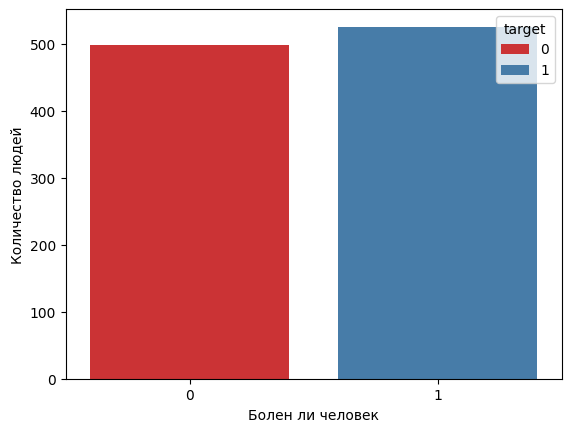

In [71]:
sns.countplot(x='target', hue='target', data=df)
plt.xlabel('Болен ли человек')
plt.ylabel('Количество людей')
plt.show()

В датасете примено поровну людей с болезнью и без.

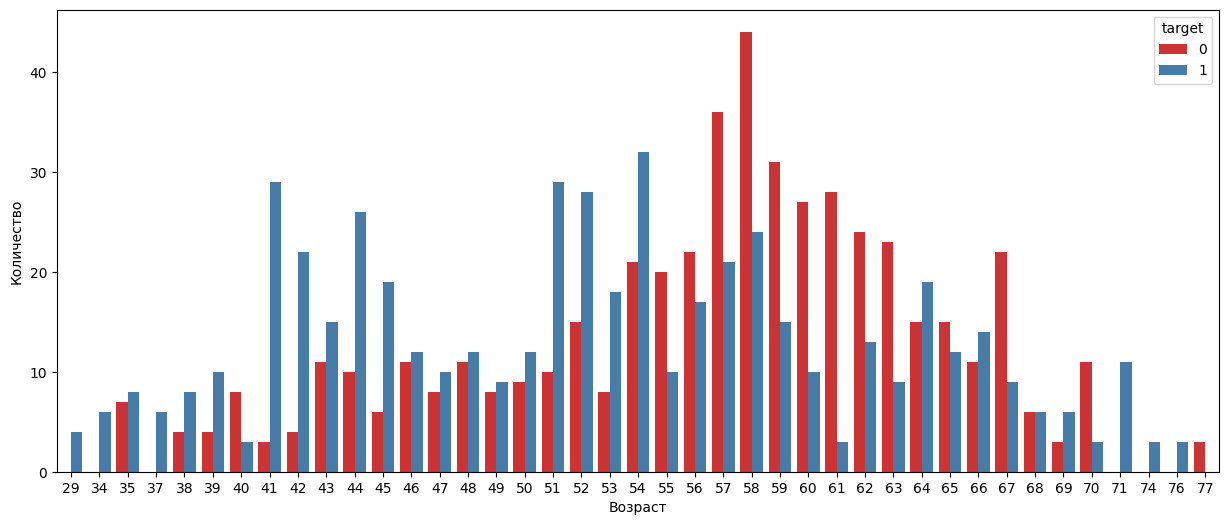

In [72]:
plt.figure(figsize=(15, 6))
sns.countplot(x='age', hue='target', data=df)
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

В выборке люди до 55 лет больны гораздо чаще.

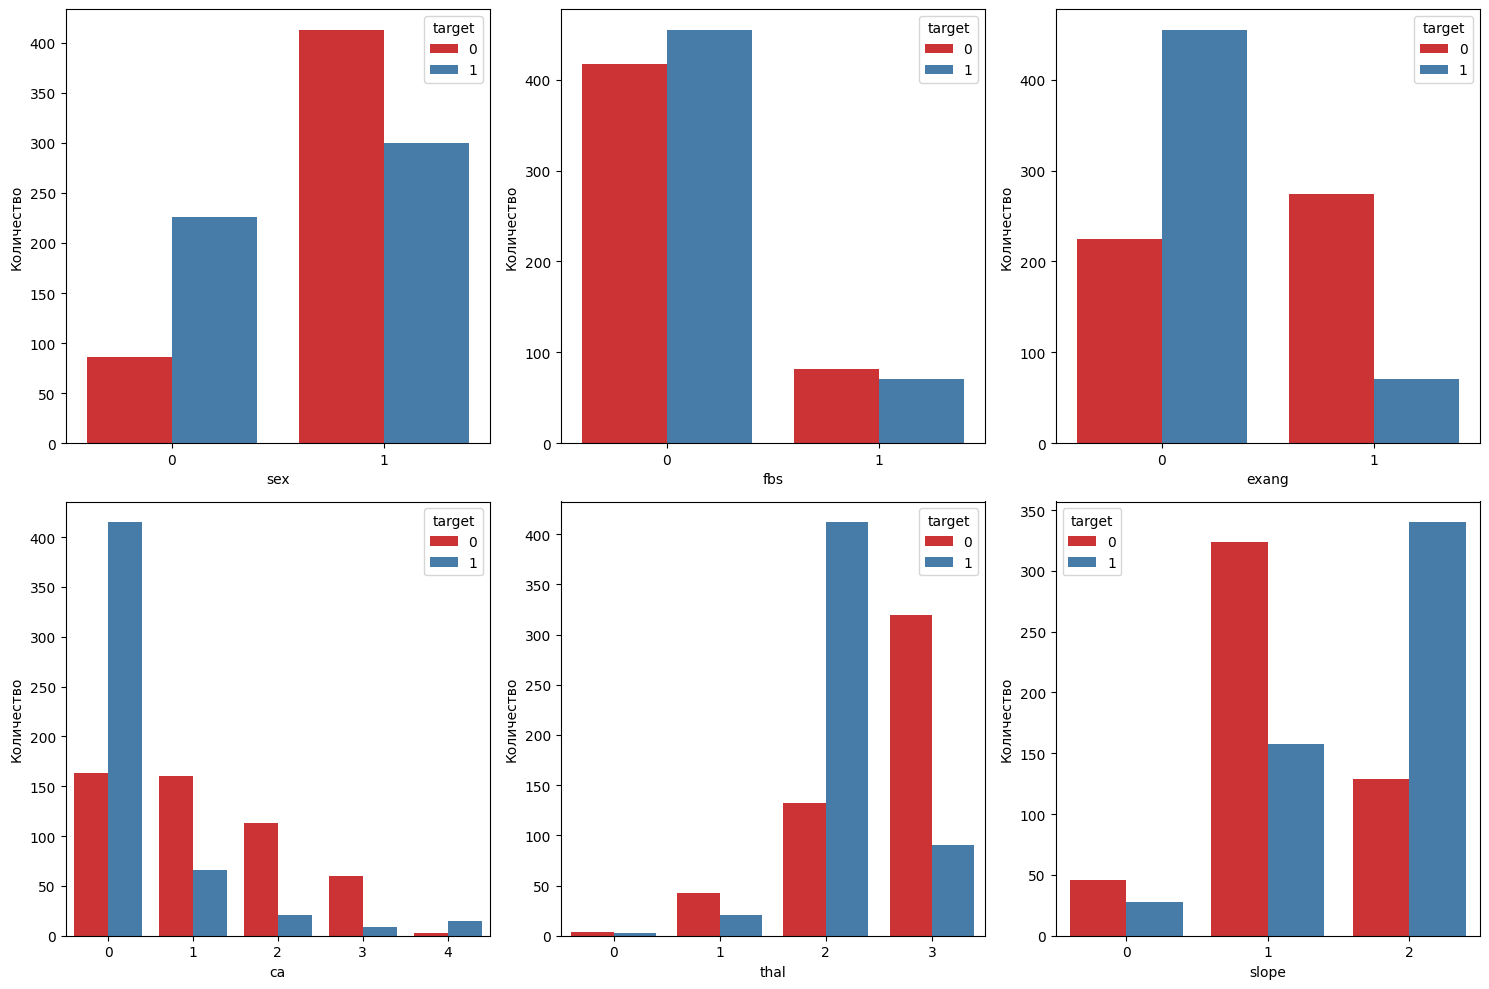

In [73]:
columns_to_plot = ['sex', 'fbs', 'exang', 'ca', 'thal', 'slope']

plt.figure(figsize=(15, 10))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=column, hue='target', data=df)
    plt.xlabel(column)
    plt.ylabel('Количество')

plt.tight_layout()
plt.show()

Женщин в датасете в два раза меньше, но болеют они при этом гораздо чаще. Более того, среди женщин больше больных, чем здоровых, а среди мужчин наоборот.
Людей с уровнем сахара > 120 гораздо больше в выборе, при этом на наличие болезни это как будто не влияет.
Люди, у которых стенокардия вызывается физическими нагрузками, больны чаще. Люди же, у которых не вызываются, чаще здоровы.
Количество магистральных сосудов (0-3), окрашенных флюороскопией явно влияет на болезнь, люди у которых 0 болеют гораздо реже, чем люди с >0.
Значения в thal и slope также явно влияют на наличие болезни.

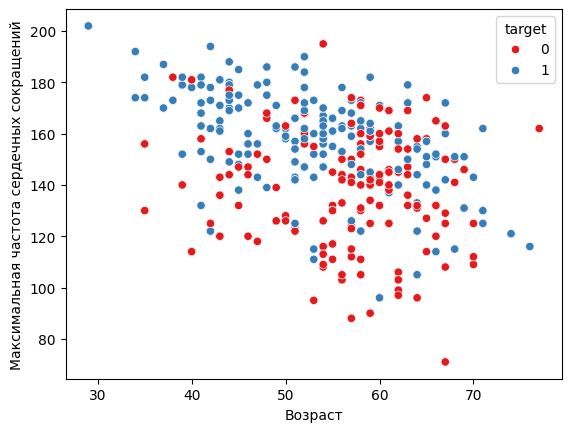

In [74]:
sns.scatterplot(x='age', y='thalach', hue='target', data=df)
plt.xlabel('Возраст')
plt.ylabel('Максимальная частота сердечных сокращений')
plt.show()

Feature engineering

Закодируем категориальные признаки `ca`, `cp`, `thal` и `slope`.

In [75]:
cp_dum = pd.get_dummies(df['cp'], prefix = "cp")
thal_dum = pd.get_dummies(df['thal'], prefix = "thal")
slope_dum = pd.get_dummies(df['slope'], prefix = "slope")
ca_dum = pd.get_dummies(df['ca'], prefix = "ca")

frames = [df, cp_dum, thal_dum, slope_dum, ca_dum]
df = pd.concat(frames, axis = 1)
df = df.drop(columns = ['cp', 'thal', 'slope', 'ca'])
df = df.drop(columns = ['restecg'])  # restecg удалим
df.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,target,cp_0,...,thal_2,thal_3,slope_0,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4
0,52,1,125,212,0,168,0,1.0,0,True,...,False,True,False,False,True,False,False,True,False,False
1,53,1,140,203,1,155,1,3.1,0,True,...,False,True,True,False,False,True,False,False,False,False
2,70,1,145,174,0,125,1,2.6,0,True,...,False,True,True,False,False,True,False,False,False,False
3,61,1,148,203,0,161,0,0.0,0,True,...,False,True,False,False,True,False,True,False,False,False
4,62,0,138,294,1,106,0,1.9,0,True,...,True,False,False,True,False,False,False,False,True,False


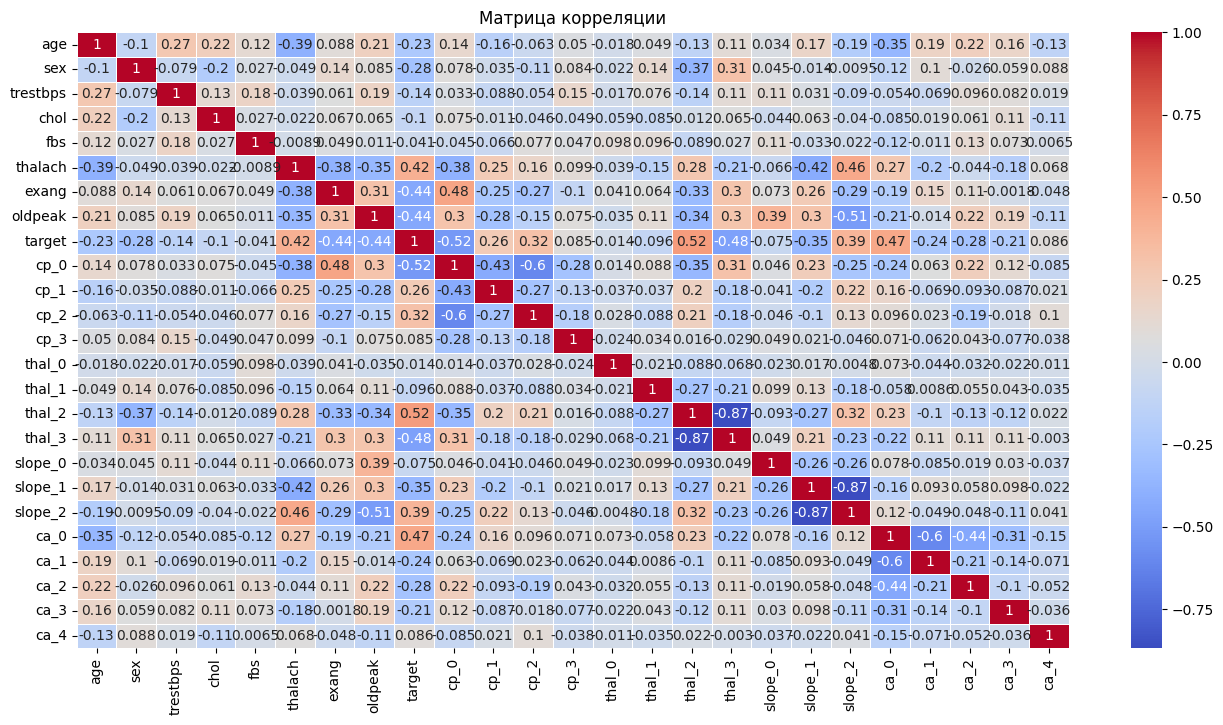

In [76]:
# Построим матрицу корреляции
corr_matrix = df.corr()
plt.figure(figsize=(16, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Матрица корреляции")
plt.show()

Между `thal_2` и `thal_3`, `slope_1` и `slope_2` есть сильные корреляции, удалим по одной колонке из пар.

In [77]:
df = df.drop(columns = ['thal_3', 'slope_1'])

Разобьем выборку на тестовую и обучающую, выполним масштабирование

In [78]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Выберем наилучшие признаки

In [79]:
logreg = LogisticRegression()

selector = RFECV(estimator=logreg, step=1, cv=5, scoring='accuracy')

selector = selector.fit(X_train_scaled, y_train)

selected_columns = X_train.columns[selector.support_]

print(f'Выбранные колонки: {selected_columns}')

X_train = selector.transform(X_train_scaled)
X_test = selector.transform(X_test_scaled)

Выбранные колонки: Index(['sex', 'trestbps', 'chol', 'thalach', 'oldpeak', 'cp_0', 'cp_2', 'cp_3',
       'thal_1', 'thal_2', 'slope_2', 'ca_0', 'ca_2', 'ca_4'],
      dtype='object')


Подберём гиперпараметры

In [80]:
models = {
    "Logistic Regression": LogisticRegression,
    "SVC": SVC,
    "KNeighbors": KNeighborsClassifier,
    "Naive Bayes": GaussianNB,
    "Decision Tree": DecisionTreeClassifier,
    "MySimpleSVMClassifier": MySimpleSVMClassifier
}

grid = {
    "Logistic Regression": {"C": [0.001, 0.01, 0.1, 1, 10, 100]},
    "SVC": {
        "C": [0.1, 1, 10, 100],
        "kernel": ["linear", "rbf", "poly", "sigmoid"],
        "degree": [2, 3, 4],
        "gamma": [0.001, 0.01, 0.1, 1],
        "coef0": [-1, 0, 1]
    },
    "KNeighbors": {
        "n_neighbors": [3, 5, 7, 10, 15],
        "weights": ['uniform', 'distance'],
        "algorithm": ["ball_tree", "kd_tree", "brute"]
    },
    "Naive Bayes": {
        "var_smoothing": np.logspace(0, -9, num=100)
    },
    "Decision Tree": {
        "criterion": ["gini", "entropy"],
        "splitter": ["best", "random"],
        "max_depth": [None, 5, 10, 15, 20],
        "min_samples_split": [2, 4, 6, 8],
        "min_samples_leaf": [1, 2, 4, 6],
        "max_features": [None, 'sqrt', 'log2']
    },
    "MySimpleSVMClassifier": {
        "learning_rate": [0.01, 0.0001],
        "num_iterations": [100, 500, 1000],
        "lambda_p": [0.01, 0.0001]
    }
}


def perform_grid_search(model, params, x_train, y_train):
    grid_search = GridSearchCV(model, params, scoring='accuracy', cv=5)
    grid_search.fit(x_train, y_train)
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    return best_params, best_score

best_params = {}
for model_name, model in models.items():
    params, score = perform_grid_search(model(), grid[model_name], X_train, y_train)
    best_params[model_name] = params
    print(f"Модель: {model_name}")
    print(f"        accuracy={score}")
    print(f"        params={params}")

Модель: Logistic Regression
        accuracy=0.88003108003108
        params={'C': 0.01}
Модель: SVC
        accuracy=0.9665306915306914
        params={'C': 100, 'coef0': 0, 'degree': 2, 'gamma': 1, 'kernel': 'poly'}
Модель: KNeighbors
        accuracy=0.9720862470862471
        params={'algorithm': 'ball_tree', 'n_neighbors': 15, 'weights': 'distance'}
Модель: Naive Bayes
        accuracy=0.8451534576534577
        params={'var_smoothing': 0.43287612810830584}
Модель: Decision Tree
        accuracy=0.974864024864025
        params={'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Модель: MySimpleSVMClassifier
        accuracy=0.8758644133644132
        params={'lambda_p': 0.01, 'learning_rate': 0.0001, 'num_iterations': 100}


Обучим модели и оценим точность, сравним модели, построив confusion matrices

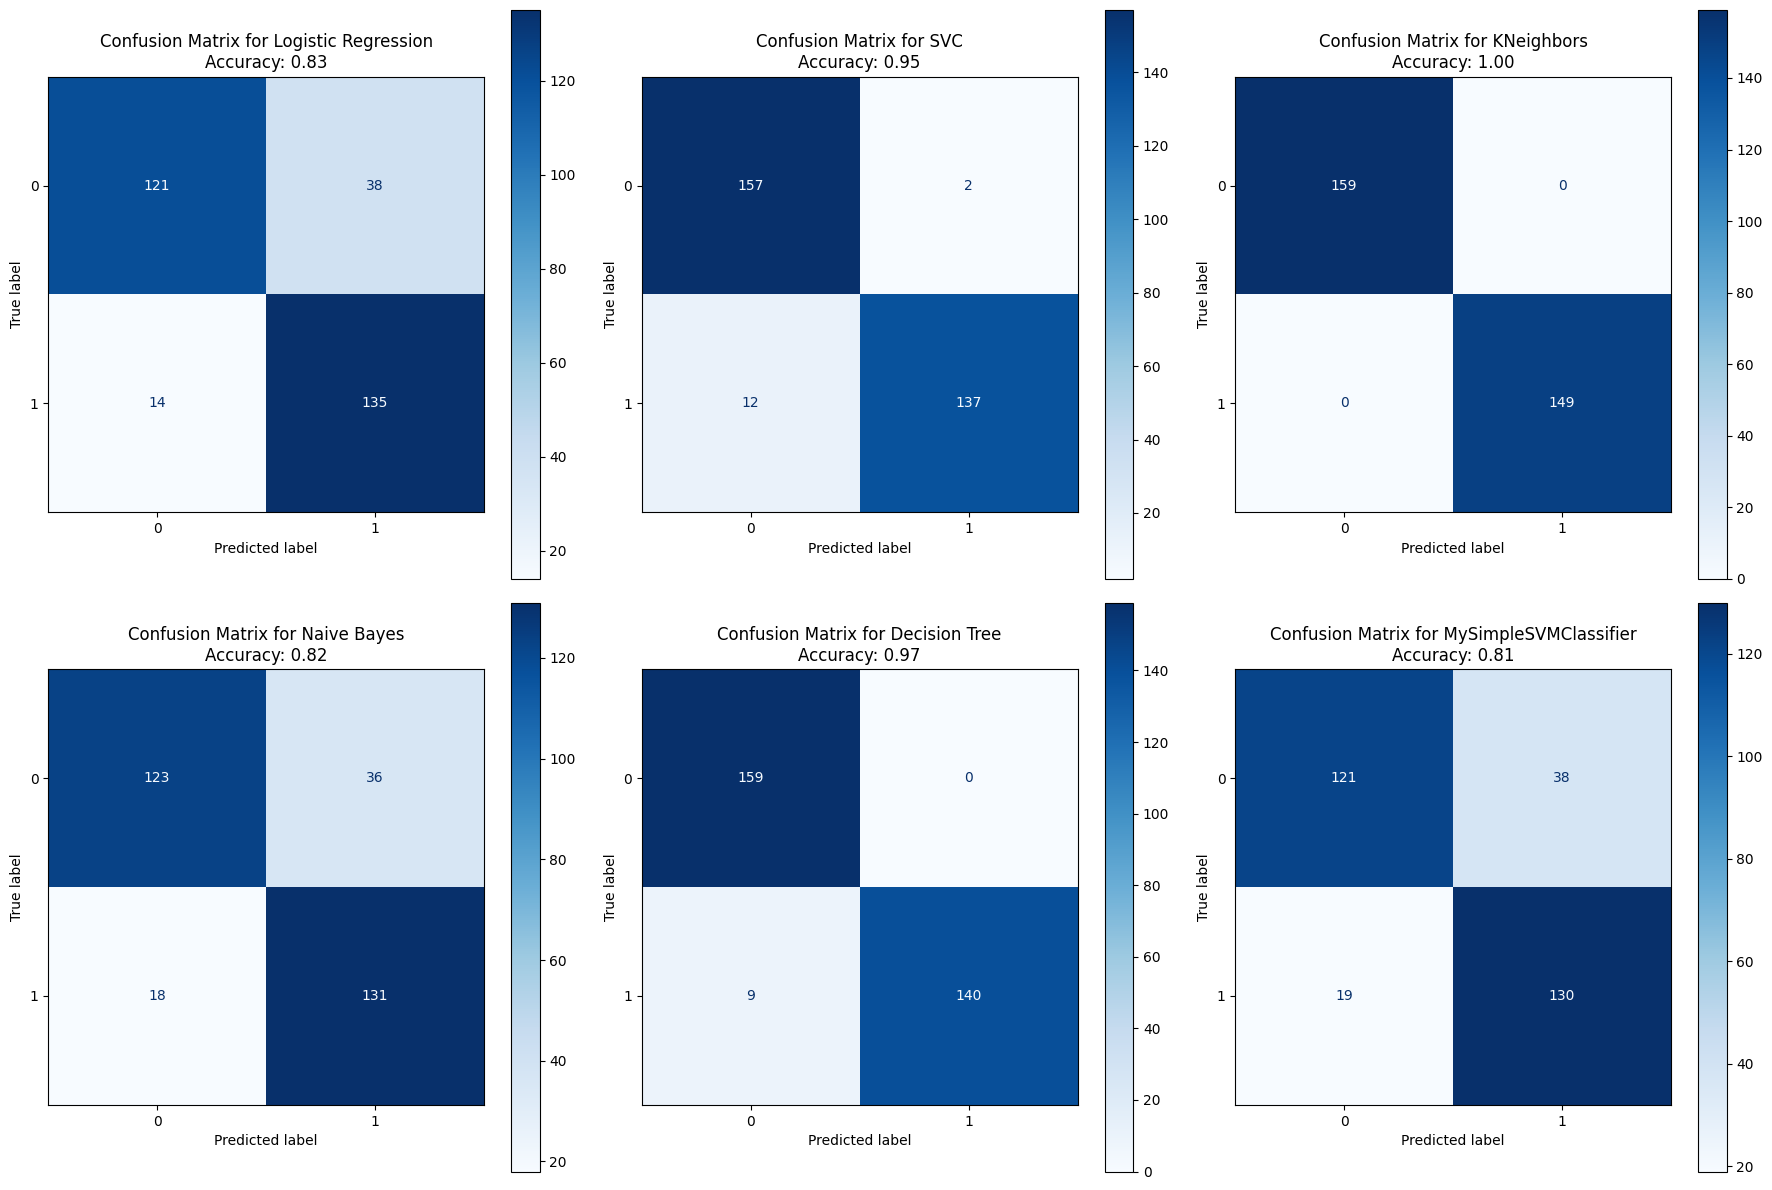

In [81]:
num_models = len(models)
cols = 3
rows = num_models // cols + (num_models % cols > 0)

plt.figure(figsize=(cols * 6, rows * 6))

for i, (model_name, model) in enumerate(models.items(), 1):
    model_instance = model(**best_params[model_name])

    model_instance.fit(X_train, y_train)

    y_pred = model_instance.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)

    plt.subplot(rows, cols, i)
    plt.title(f"Confusion Matrix for {model_name}\nAccuracy: {accuracy:.2f}")
    ConfusionMatrixDisplay(cm, display_labels=model_instance.classes_).plot(values_format='d', cmap='Blues', ax=plt.gca())

plt.tight_layout()
plt.show()

Наилучшее качество показали KNeighbors, Decision Tree и SVC.
Реализованная мною SVM модель сравнима с библиотечными Naive Bayes и Logistic Regression.